<a href="https://colab.research.google.com/github/FranciscaAlliende/APS-Failure-at-Scania-Trucks/blob/master/Cost_Sentive_Learning_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')

In [7]:
!pip install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in /usr/local/lib/python3.6/dist-packages (0.7.0)


In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
# my libraries
import basic_prepro as bp
import null_values as nv
import evaluation_metrics as em

In [10]:
# import data
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/aps_failure_training_set.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/aps_failure_test_set.csv')

In [11]:
# basic prepocessing
train = bp.data_prepro(train)
test = bp.data_prepro(test)

In [12]:
[y_train, X_train, y_test, X_test] = nv.null_values(train, test, t=0.5)

False positives:  19
False negatives:  107
Total cost: 53690
Confusion matrix, without normalization


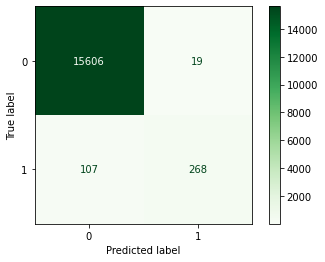

     Normalized confusion matrix


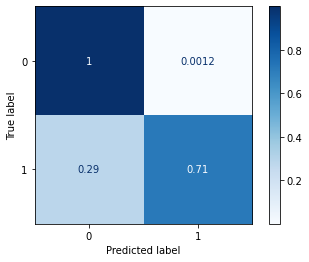

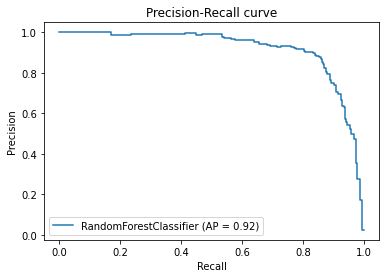

f1 score 0.81
precision:  0.934
recall 0.715


(53690, 0.809667673716012, 0.9337979094076655, 0.7146666666666667)

In [15]:
# RF
clf = RandomForestClassifier(random_state=333) 
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
em.evaluation_metrics(y_pred, y_test, X_test, clf, c1=10, c2=500)

False positives:  833
False negatives:  6
Total cost: 11330
Confusion matrix, without normalization


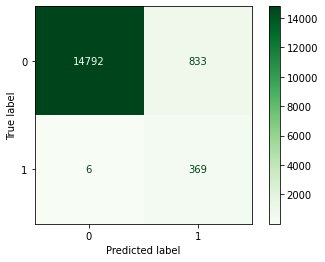

     Normalized confusion matrix


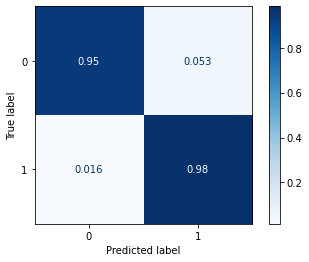

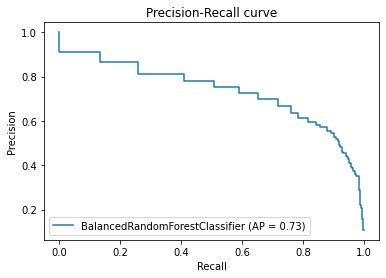

f1 score 0.468
precision:  0.307
recall 0.984


(11330, 0.4679771718452759, 0.3069883527454243, 0.984)

In [18]:
# Balanced Random Forest with class weight: balanced subsample
clf = BalancedRandomForestClassifier(random_state=333, class_weight="balanced_subsample")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

em.evaluation_metrics(y_pred, y_test, X_test, clf, c1=10, c2=500)

False positives:  816
False negatives:  12
Total cost: 14160
Confusion matrix, without normalization


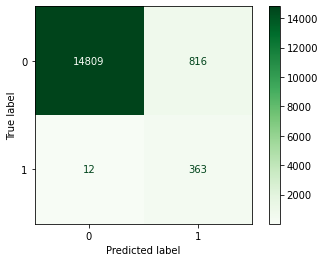

     Normalized confusion matrix


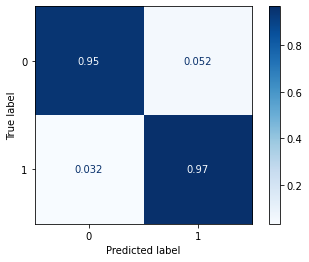

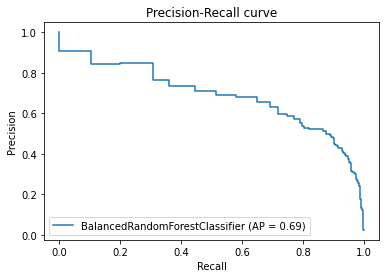

f1 score 0.467
precision:  0.308
recall 0.968


(14160, 0.4671814671814671, 0.30788804071246817, 0.968)

In [19]:
# Balanced Random Forest with class weight: balanced 
clf = BalancedRandomForestClassifier(random_state=333, class_weight="balanced")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

em.evaluation_metrics(y_pred, y_test, X_test, clf, c1=10, c2=500)

False positives:  11
False negatives:  165
Total cost: 82610
Confusion matrix, without normalization


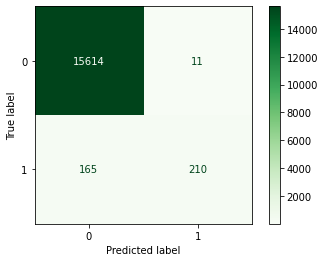

     Normalized confusion matrix


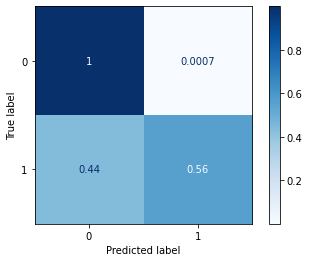

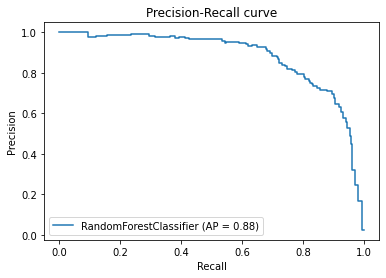

f1 score 0.705
precision:  0.95
recall 0.56


(82610, 0.7046979865771812, 0.9502262443438914, 0.56)

In [20]:
# WRF build-in weight
clf = RandomForestClassifier(random_state=333, class_weight="balanced") #"balanced", uses the inverse weighting from the training dataset, giving focus to the minority class.
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

em.evaluation_metrics(y_pred, y_test, X_test, clf, c1=10, c2=500)

In [47]:
# WRF custom weight
# divide de test set into validation and test
X_test2, X_val, y_test2, y_val = train_test_split(X_test, y_test, test_size=0.33, random_state=333)

print(X_val.shape)
print(y_val.shape)
print(X_test2.shape)
print(y_test2.shape)

(5280, 162)
(5280,)
(10720, 162)
(10720,)


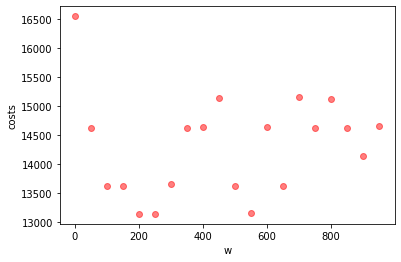

In [52]:
# WRF custom weight
w = 1
ws = []
costs = []

while w < 1002:
  clf = RandomForestClassifier(random_state=333, class_weight={0: w, 1: 1})
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_val)

  tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
  c1 = 10
  c2 = 500
  cost = c1*fp + c2*fn

  ws.append(w)
  costs.append(cost)
  w += 50

plt.scatter(ws, costs, c="r", alpha=0.5)
plt.xlabel("w")
plt.ylabel("costs")
plt.show()

False positives:  23
False negatives:  55
Total cost: 27730
Confusion matrix, without normalization


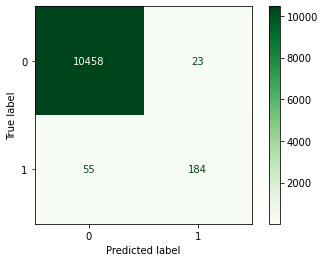

     Normalized confusion matrix


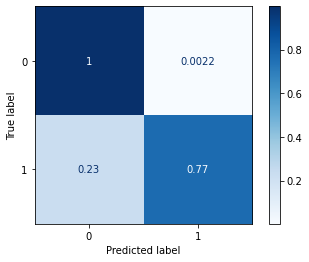

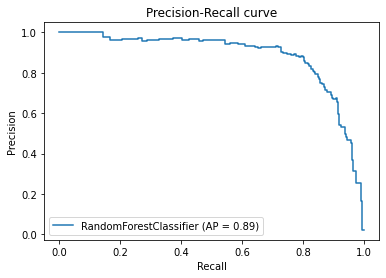

f1 score 0.825
precision:  0.889
recall 0.77


(27730, 0.8251121076233183, 0.8888888888888888, 0.7698744769874477)

In [53]:
# predict with the chosen w
w = 200
clf = RandomForestClassifier(random_state=333, class_weight={0: w, 1: 1})
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test2)

em.evaluation_metrics(y_pred, y_test2, X_test2, clf, c1=10, c2=500)